# Import dependencies

In [59]:
import mesa
from mesa import Agent, Model
from mesa.datacollection import DataCollector
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Model implementation


The simulation aims to model the placement stage of money laundering, where illicit funds are placed into the financial system via small, frequent transactions. The financial institution monitors transaction patterns, calculates suspicious scores, and flags accounts that exhibit unusual behavior based on thresholds.

In the following code block, you can see three diffrent classes that help us in simuation.

1. **`FinancialInstitution` Class**


The FinancialInstitution class represents the role of the bank or financial institution in this money laundering model. It serves as the regulatory body that monitors all customer transactions and flags suspicious activity. It has several thresholds used to define suspicious behaviors:

- `num_transaction_threshold`: Maximum number of transactions allowed before the account is flagged.
- `amount_threshold`: Maximum transaction amount before being considered suspicious.
- `time_difference_threshold`: The minimum time difference between transactions. Transactions that occur too close together may be flagged.
- `suspicious_score_threshold`: The limit of the suspicious score that, if exceeded, flags an account.

Methods:

- `calculate_suspicious_score()`: This function assesses whether the most recent transaction is suspicious based on its amount and time difference from previous transactions. If deemed suspicious, it increases the customer's suspicious score. Multiple consecutive suspicious transactions lead to exponential growth of the suspicious score.
- `monitor_transaction_history()`: This function checks if the customer's history or suspicious score exceeds predefined thresholds, determining if their account should be flagged.


2. **`Customer` Class**


The Customer class models individual users of the bank, some of whom might be money launderers. It inherits from the Mesa Agent class. The key attributes for the Customer class are:


-`is_launderer`: Boolean flag indicating if the customer is engaging in laundering. We use this attributes to have control on the transaction patternes of the custoemrs we would like to consider as launderer.
- `percent_laundery`: The percentage of creating agents as launderers. 
- `account_balance`: The customer's starting balance which is initialized randomly. 
- `history_log`: A list of past transactions, tracking the amount and time difference between transactions.
- `status`: Either "normal" or "flagged" based on their suspicious score. At the beginning, we assume all customers are normal. In the iteration of modeling, if the model determines the customer transactions are not normal, the customer will be flagged and not allowed to perform more transactions. 
- `suspicious_score`: A score assigned based on the customer's transaction history. We initially assigned a value based on the customer's initial balance amount. More balance, greater suspicious score. 

Method:

- `transaction()`: Simulates a single transaction for the customer. The amount and time difference between transactions are randomly generated. Money launderers have different ranges for these values, simulating their more frequent, larger transactions. The customer's suspicious score and status are updated after each transaction.


In [20]:
class FinancialInstitution:
  def __init__(self, model, num_transaction_threshold, amount_threshold, time_difference_threshold, suspicious_score_threshold):
    self.model = model
    self.num_transaction_threshold = num_transaction_threshold
    self.amount_threshhold = amount_threshold
    self.time_difference_threshold = time_difference_threshold
    self.suspicious_score_threshold = suspicious_score_threshold

  def calculate_suspicious_score(self, customer):
    last_trans_amount, last_trans_time = customer.history_log[-1]
    if last_trans_time < self.time_difference_threshold or last_trans_amount > self.amount_threshhold:
      customer.suspicious_score += .05
      for i in range(-2, -len(customer.history_log),-1):
        trans_amount, trans_time = customer.history_log[i]
        if trans_time < self.time_difference_threshold  or trans_amount > self.amount_threshhold:
          customer.suspicious_score += .05**(-i)

  def monitor_transaction_history(self, customer):
      if len(customer.history_log) >= self.num_transaction_threshold or customer.suspicious_score >= self.suspicious_score_threshold:
        return "flag"                
      return "normal"
  
class Customer(Agent):
  def __init__(self, model, is_launderer, percent_laundery) :
    super().__init__(model)
    self.is_launderer = is_launderer
    self.percent_laundery = percent_laundery
    self.account_balance = np.random.randint(100, 500000)## use random method of Agent
    self.history_log = []
    self.status = "normal"
    if self.account_balance> 50000:
      self.suspicious_score =.05
    elif self.account_balance>100000:
      self.suspicious_score = .1
    else:
      self.suspicious_score =.15

  def transaction(self):
    if self.status == "normal": # falg customers are not allowed to perform more tranactions

      ## randomly select amount and time diffrence for regular customers:

      ## randomely select a value between 10$ to 1000$ for customers
      amount= np.random.randint(10,3000)
      # for regular customers time difference should be between -24 hours  and 24 hours (one day after), at the end we do not cosider negative time difference.
      # We use negative time difference to have this option to not to continue with nagative time diffrence as not doing any transaction
      # It helps to opt out of doing a transaction for usual customers
      time_difference = np.random.randint(-24*60, 24*60) # For a reqular customer, the probability of doing a transaction is the same the one of not doing a transaction
      ## randomely select the amount of transaction and time difference between this transaction and the precious one

      ## randomly select amount and time diffrence for launderes
      if self.is_launderer:
        ## randomely pick a value between 200$ to 2000$ 
        amount = np.random.randint(200, 2000)
        ## randomely pick time difference (in minutes) between this trasnaction and the previous one
        ## for launderes time difference should be between -10 minutes (1h) and 60 minutes
        time_difference = np.random.randint(-10, 60) # For a launderer, the probability of doing a transaction is 6 times more than not doing a transaction

      if time_difference > 0: 

        self.account_balance += amount
        self.history_log.append((amount, time_difference))
        self.model.bank.calculate_suspicious_score(self)
        self.status = self.model.bank.monitor_transaction_history(self)




class MoneyLaunderingModel(Model):
    def __init__(self, n):
      super().__init__()
      self.num_agents = n
      self.bank = FinancialInstitution(model = self, num_transaction_threshold=40, amount_threshold=30000, time_difference_threshold=40, suspicious_score_threshold=1)
      self.percent_laundery = .01
      self.datacollector = DataCollector(agent_reporters={"Suspicious_score": "suspicious_score", "Balance": "account_balance", "Status": "status"})

        # Generate the is_launderer list, which will be passed as a keyword argument
      is_launderer_list = self.random.choices([False, True], k = n, weights=[1 - self.percent_laundery, self.percent_laundery])

        # Use the create_agents method from Mesa
      Customer.create_agents(model=self, n=n, is_launderer = is_launderer_list, percent_laundery= self.percent_laundery)

    def step(self):
        self.datacollector.collect(self)
        self.agents.shuffle_do("transaction")


# Run the simulation

In [107]:
num_agents =1000
model = MoneyLaunderingModel(num_agents)  # Tells the model to create 10 agents
for _ in range(30): ## the number of iteration has a direct correlation with `num_transaction_threshold` since each iteration means performing a transaction. 
    model.step()

In [21]:
## if you want to get more insight of what happens in each iteration, you can uncomment this code cell and run it.

num_agents =1000
model = MoneyLaunderingModel(num_agents) 
for step in range(50):
    model.step()
    for a in model.agents:
        if a.status == "flag":
            print(f"Agent {a.unique_id} was flagged at step {step}")
            print(f"Agent {a.unique_id} has {a.suspicious_score} suspicious score")
            print(f"Agent {a.unique_id} has {a.history_log} transaction history")
            print(f"Agent {a.unique_id} did {len(a.history_log)} transactions")

Agent 475 was flagged at step 25
Agent 475 has 1.0419733379501377 suspicious score
Agent 475 has [(1505, 18), (951, 3), (1585, 18), (439, 56), (822, 21), (1941, 13), (715, 37), (370, 6), (1173, 19), (857, 14), (1401, 38), (1231, 17), (1115, 9), (1256, 26), (585, 11), (728, 32), (768, 38), (210, 29), (1235, 10), (1650, 6)] transaction history
Agent 475 did 20 transactions
Agent 105 was flagged at step 26
Agent 105 has 1.0418286019735754 suspicious score
Agent 105 has [(1650, 22), (1241, 3), (1371, 32), (1039, 9), (1376, 29), (535, 17), (946, 55), (868, 55), (1809, 46), (1464, 7), (1712, 7), (1764, 14), (336, 35), (1906, 22), (1582, 14), (1443, 4), (495, 9), (1417, 33), (1255, 8), (1034, 24), (1162, 15), (283, 19)] transaction history
Agent 105 did 22 transactions
Agent 475 was flagged at step 26
Agent 475 has 1.0419733379501377 suspicious score
Agent 475 has [(1505, 18), (951, 3), (1585, 18), (439, 56), (822, 21), (1941, 13), (715, 37), (370, 6), (1173, 19), (857, 14), (1401, 38), (1231

# Analyze the result

In [ ]:
# Create a DataFrame to hold the agent status and is_launderer values at the end of simulation

status = [a.status for a in model.agents]
is_launderer =  [a.is_launderer for a in model.agents]
len_history_log_agents = [len(a.history_log) for a in model.agents]

data = pd.DataFrame({
    "status": status,
    "is_launderer": is_launderer,
    "number_transactions":len_history_log_agents
})



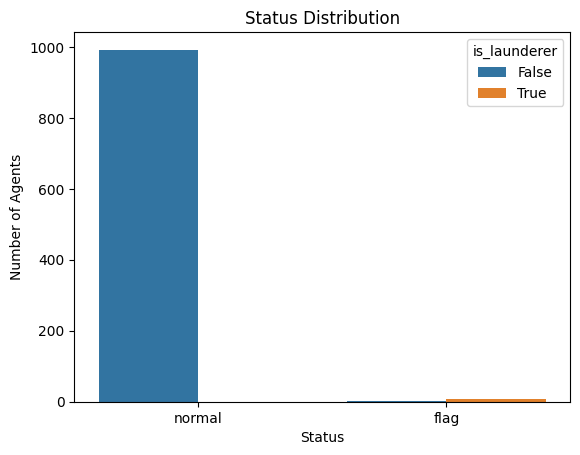

In [70]:
# Create a countplot with seaborn
visualization = sns.countplot(x="status", hue="is_launderer", data=data)
visualization.set(
    title="Status Distribution", xlabel="Status", ylabel="Number of Agents"
); 

In [29]:
id_launderer = []
id_flag_status = []
for i in range(1000):
    if is_launderer[i] == True:
        id_launderer.append(i+1) # agent unique ids starts from 1.
    if status[i] == "flag":
        id_flag_status.append(i+1)

print("Unique id of the launderer agents:", id_launderer)
print("Unique id of the agents who were flagged during simulation:", id_flag_status)
print("\n")
print("Percentage of launderers who were flagged:", len(set(id_flag_status).intersection(set(id_launderer)))/len(id_launderer))
print("Percentage of regular custoemrs who were flagged incorrectly:", len(set(id_flag_status).difference(set(id_launderer)))/(num_agents-len(id_launderer)))


Unique id of the launderer agents: [105, 153, 162, 359, 475, 547, 693]
Unique id of the agents who were flagged during simulation: [70, 105, 153, 162, 359, 475, 547, 693]


Percentage of launderers who were flagged: 1.0
Percentage of regular custoemrs who were flagged incorrectly: 0.0010070493454179255


In [31]:
## Create dataframe from simulation data in each step of simulation

collected_data = model.datacollector.get_agent_vars_dataframe()
collected_data.tail(30)

Suspicious_score  Balance  Status
Step AgentID                                   
50   971              0.150000    91718  normal
     972              0.050000    96751  normal
     973              0.150000    63130  normal
     974              0.100000   408093  normal
     975              0.050000   386228  normal
     976              0.100000   483320  normal
     977              0.050000   342001  normal
     978              0.150000    59113  normal
     979              0.050000    87740  normal
     980              0.050000   377718  normal
     981              0.050000   507040  normal
     982              0.100000   398348  normal
     983              0.250125   537205  normal
     984              0.100000   482019  normal
     985              0.100000   520738  normal
     986              0.050000   118276  normal
     987              0.050000   165465  normal
     988              0.100000   169604  normal
     989              0.100000   407494  normal
     990              0.050000   302825  normal
     991              0.050000    87719  normal
     992              0.050000   267524  normal
     993              0.100000   180755  normal
     994              0.050000   447082  normal
     995              0.050000   263700  normal
     996              0.050000   320115  normal
     997              0.100000   140447  normal
     998              0.150000    54880  normal
     999              0.200000    40949  normal
     1000             0.050000   335121  normal

In [32]:
## Customers who were falgged
flagged_data = collected_data[collected_data["Status"] == "flag"]
flagged_data

Suspicious_score  Balance Status
Step AgentID                                  
27   475              1.041973   215379   flag
28   105              1.041829   485642   flag
     475              1.041973   215379   flag
29   105              1.041829   485642   flag
     475              1.041973   215379   flag
...                        ...      ...    ...
50   162              1.026322   454643   flag
     359              0.971296   210408   flag
     475              1.041973   215379   flag
     547              1.028828   189952   flag
     693              1.034210   367246   flag

[113 rows x 3 columns]

In [34]:
sample_agent_id_flag = id_flag_status[1] # select the first agent who were flagged
collected_data.xs(sample_agent_id_flag, level='AgentID')

,Suspicious_score,Balance,Status
Step,,,
1,0.050000,458954,normal
2,0.100000,460604,normal
3,0.100000,460604,normal
4,0.150000,461845,normal
5,0.150000,461845,normal
6,0.202500,463216,normal
7,0.255125,464255,normal
8,0.307756,465631,normal
9,0.360388,466166,normal


Text(0.5, 1.0, 'Balance of a Flagged Customer Over Time')

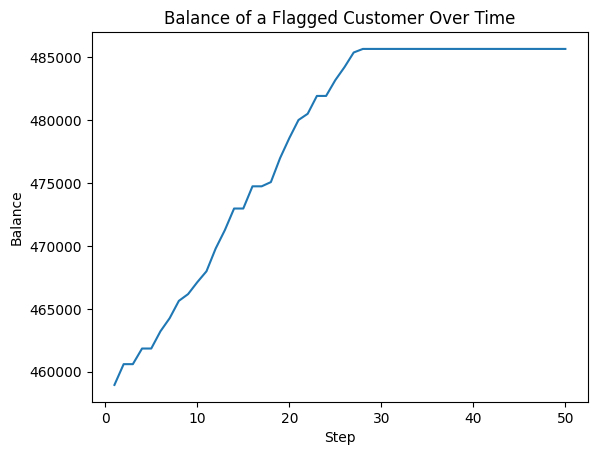

In [63]:
sns.lineplot(data = collected_data.xs(sample_agent_id_flag, level='AgentID'), x = "Step" , y= "Balance" )
plt.title("Balance of a Flagged Customer Over Time")


Text(0.5, 1.0, 'Suspicious Score of a Flagged Customer Over Time')

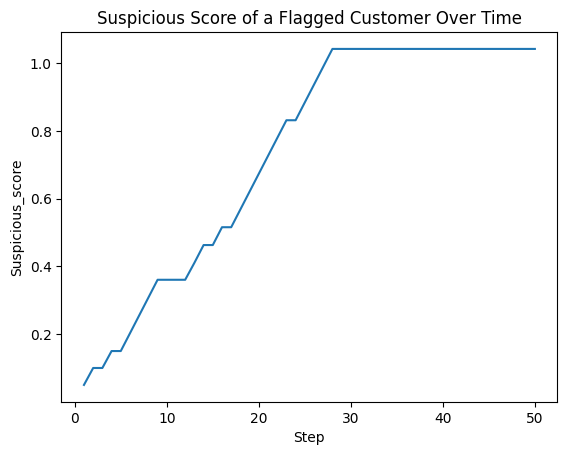

In [64]:
sns.lineplot(data = collected_data.xs(sample_agent_id_flag, level='AgentID'), x = "Step" , y= "Suspicious_score" )
plt.title("Suspicious Score of a Flagged Customer Over Time")


Text(0.5, 1.0, 'Suspicious Score Over Time: Flagged vs Normal Agent')

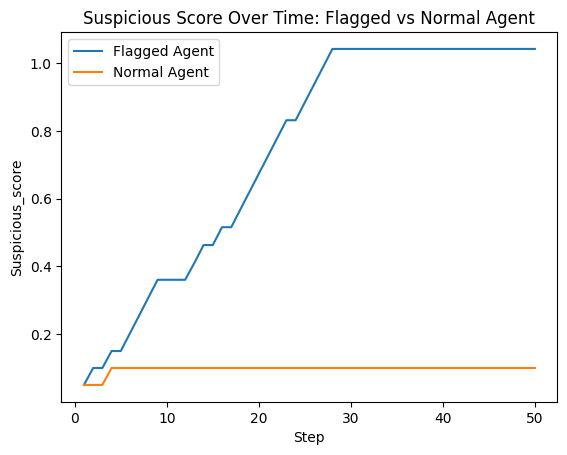

In [62]:

sample_agent_id_normal = np.random.choice(list(set(range(1, num_agents+1)).difference(id_flag_status)), 1)

sns.lineplot(data = collected_data.xs(sample_agent_id_flag, level='AgentID'), x = "Step" , y= "Suspicious_score", label= "Flagged Agent" )
sns.lineplot(data = collected_data.xs(int(sample_agent_id_normal[0]), level='AgentID'), x = "Step" , y= "Suspicious_score", label = "Normal Agent"  )
plt.title("Suspicious Score Over Time: Flagged vs Normal Agent")


(0.0, 0.002)

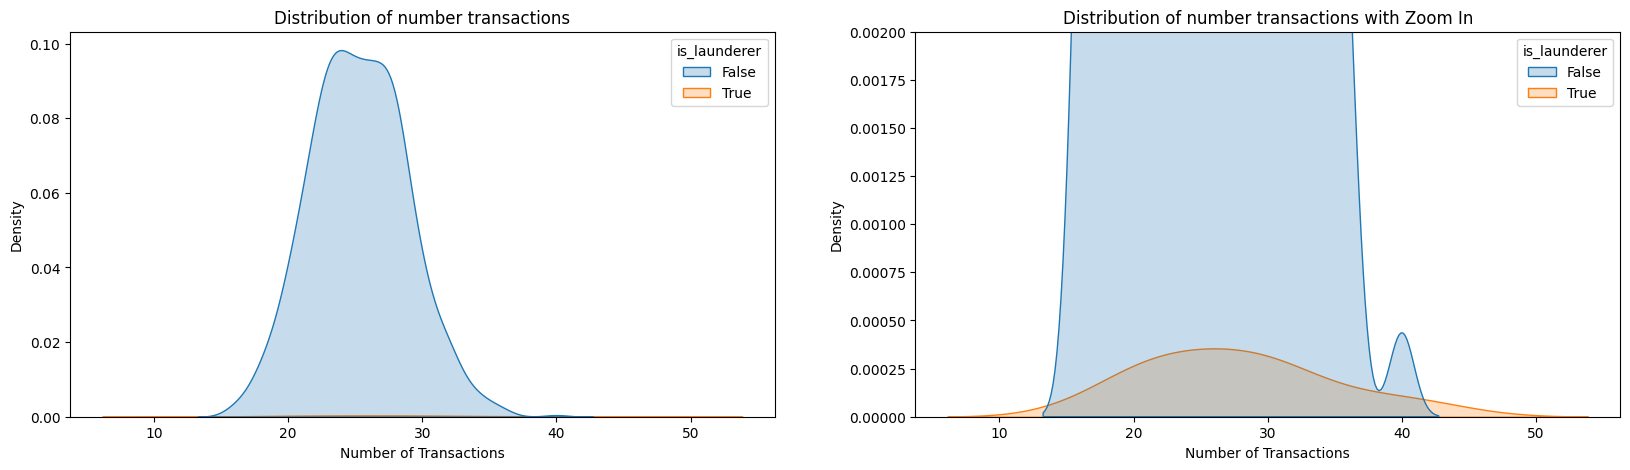

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))

# First plot (without zoom in)
sns.kdeplot(data=data, x="number_transactions", hue="is_launderer", fill=True, ax=axis[0])
axis[0].set_title("Distribution of number transactions")
axis[0].set_xlabel("Number of Transactions")
axis[0].set_ylabel("Density")

# Second plot (with zoom in on the y-axis)
sns.kdeplot(data=data, x="number_transactions", hue="is_launderer", fill=True, ax=axis[1])
axis[1].set_title("Distribution of number transactions with Zoom In")
axis[1].set_xlabel("Number of Transactions")
axis[1].set_ylabel("Density")
axis[1].set_ylim(0, 0.002)  # Adjust the y-axis limits as per your data


In [100]:
## Add initial and final balance columns to the data DataFrame from more analysis

initial_balance = collected_data.xs(1, level='Step')["Balance"]
final_balance = [a.account_balance for a in model.agents]

data["initial_balance"] = initial_balance.values
data["final_balance"] = final_balance
data

,status,is_launderer,Number_transactions,initial_balance,final_balance
0,normal,False,33,29935,86752
1,normal,False,24,263876,296974
2,normal,False,18,22382,47416
3,normal,False,27,191421,236360
4,normal,False,27,420892,460907
...,...,...,...,...,...
995,normal,False,20,294151,320790
996,normal,False,26,97321,141417
997,normal,False,28,17625,54880
998,normal,False,25,287,40949


(0.0, 2.5e-07)

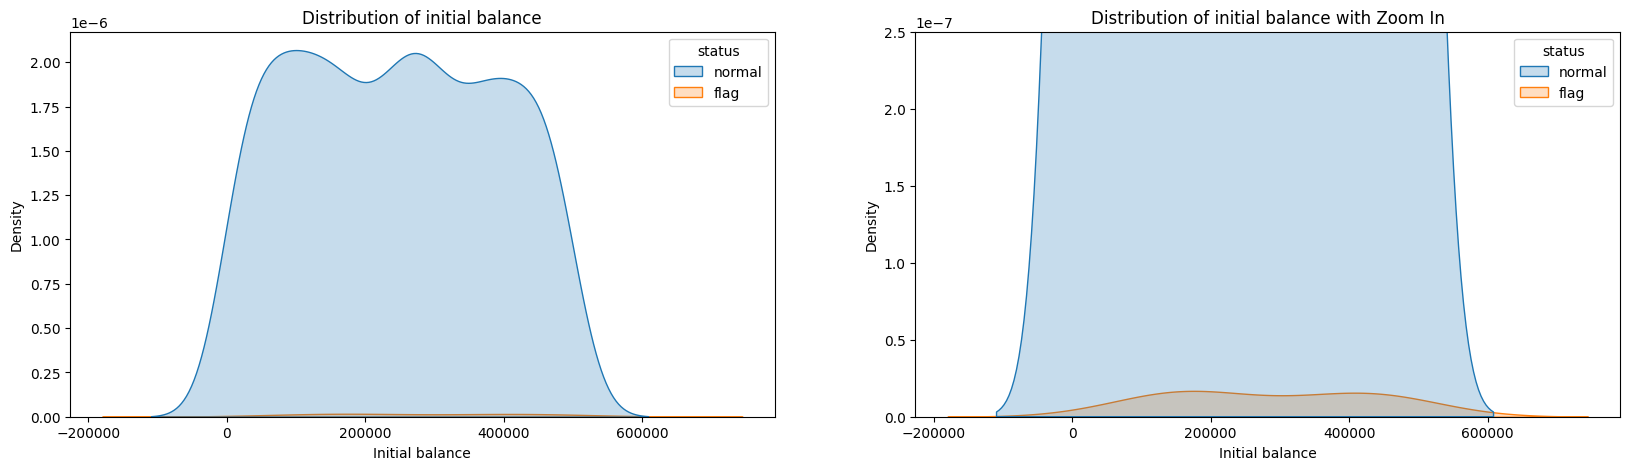

In [116]:
fig, axis = plt.subplots(1, 2, figsize=(20, 5))

# First plot (without zoom in)
sns.kdeplot(data = data, x = "initial_balance", hue = "status", fill= True, ax=axis[0])
axis[0].set_title("Distribution of initial balance")
axis[0].set_xlabel("Initial balance")
axis[0].set_ylabel("Density")

# Second plot (with zoom in on the y-axis)
sns.kdeplot(data = data, x = "initial_balance", hue = "status", fill= True, ax=axis[1])
axis[1].set_title("Distribution of initial balance with Zoom In")
axis[1].set_xlabel("Initial balance")
axis[1].set_ylabel("Density")
axis[1].set_ylim(0, .25e-6)  # Adjust the y-axis limits as per your data

(0.0, 2.5e-07)

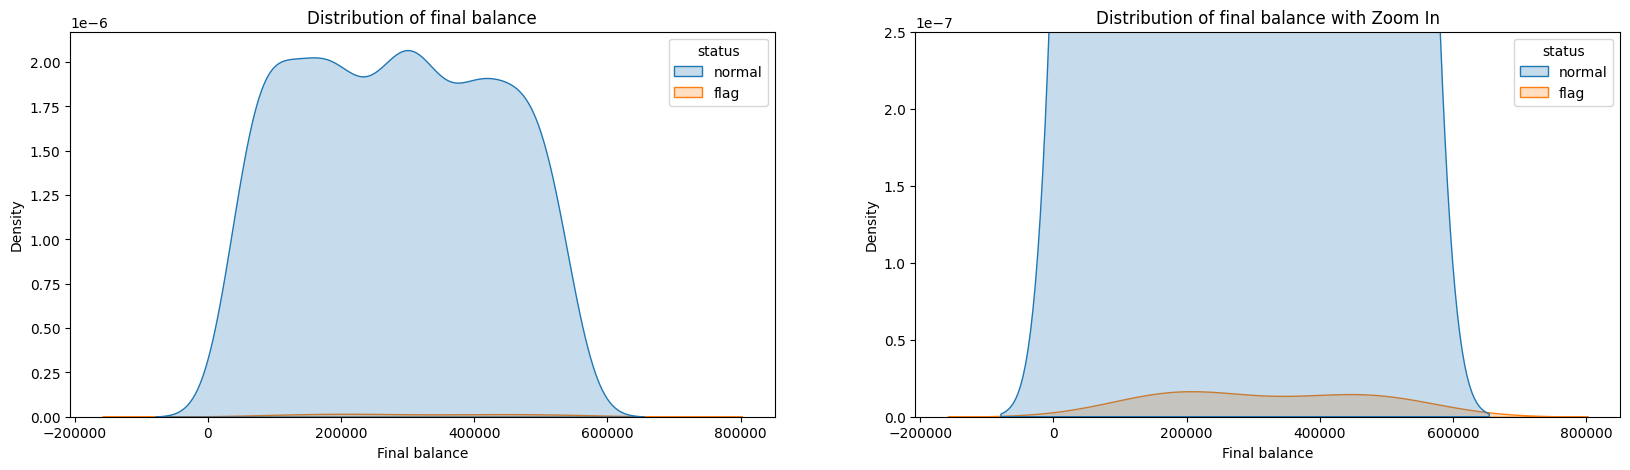

In [117]:


fig, axis = plt.subplots(1, 2, figsize=(20, 5))

# First plot (without zoom in)
sns.kdeplot(data = data, x = "final_balance", hue = "status", fill= True, ax=axis[0])
axis[0].set_title("Distribution of final balance")
axis[0].set_xlabel("Final balance")
axis[0].set_ylabel("Density")

# Second plot (with zoom in on the y-axis)
sns.kdeplot(data = data, x = "final_balance", hue = "status", fill= True, ax=axis[1])
axis[1].set_title("Distribution of final balance with Zoom In")
axis[1].set_xlabel("Final balance")
axis[1].set_ylabel("Density")
axis[1].set_ylim(0, .25e-6)  # Adjust the y-axis limits as per your data


In [114]:
.25e-6

2.5e-07

<Axes: xlabel='final_balance', ylabel='Density'>

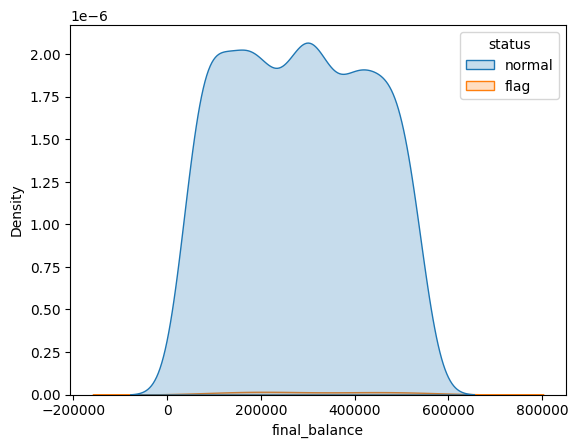

In [104]:
sns.kdeplot(data = data, x = "final_balance", hue = "status", fill= True)
